# Problem 3c (using a 2D Laplace Solver)

#### Created 01.2018 | I.J. Rodriguez (Github: space-isa)

[HOMEWORK NOTE: Since we are interested in taking a snapshot of the potential, I am taking advantage of symmetry to reduce the 3D problem to a 2D one that looks at a slice at x=0. This allowed me to reuse code created for a personal project.]

The Laplace equation is given as,

<center>$ \nabla^2 \phi = 0 $ </center>   

where $\phi$ is the potential. Here's the same equation in 2D (using Cartesian coordinates), 


<center>$\frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = 0 $</center>  
 
In order to solve for the potential numerically, we have to express the above equation in a *discretized* form. There are different ways of going about this, but for our purposes we'll stick with the textbook central differening method.  

<center>$ \frac{\phi^n_{i+1,j}-2\phi^n_{i,j}+\phi^n_{i-1,j}}{\Delta x^2} + \frac{\phi^n_{j+1}-2\phi^n_{j}+\phi^n_{i,j-1}}{\Delta y^2} = 0 $</center>

Solving for $ \phi^n_{i,j} $ we get an equation whose form we can use in our code, 

<center>$ \phi^n_{i,j} = \frac{\Delta y^2 (\phi^n_{i+1,j} + \phi^n_{i-1,j}) + \Delta x^2 (\phi^n_{j+1} + \phi^n_{j-1})}{2(\Delta x^2 + \Delta y^2)} $</center>

  In this scenario, we have a cube with the top and bottom faces held at a potential $V$, while the others are held at ground ($V = 0$). We will assume that the potential is initially zero everywhere. The boundary conditions are outlined below: 

<center>1. $\Phi = 0$ at $y = -a$ <br>
2. $\Phi = 0$ at $y = a$ <br>
3. $\Phi = V$ at $z = -a$ <br>
4. $\Phi = V$ at $z = a$</center>

We begin by importing the appropriate Python libraries. 

In [192]:
import numpy as np
import math
from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

Let's now use our descritized equation to build a function that we'll use to iteratively solve for the potential.

<center>$ \phi^n_{i,j} = \frac{\Delta y^2 (\phi^n_{i+1,j} + \phi^n_{i-1,j}) + \Delta x^2 (\phi^n_{j+1} + \phi^n_{j-1})}{2(\Delta x^2 + \Delta y^2)} $</center>


## Defining the Laplace equation [1]

Python functions are a generalized set of instructions that we later feed information to. This one will take eight arguments: our potential array, boundary conditions, the cell sizes, and our tolerance. 

*[Note: We are going to need to define two functions. The one below will be used to solve for the potential; the other (used in our main cycle) will be used to plot the data.]* 

In [193]:
start_time = time.clock() #keeping track of computational time 

def laplace2d(V, VT, VB, VL, VR, dx, dy, tol):
    """This is where the magic happens."""

    l1norm = 1
    Vn = np.empty_like(V)

    while l1norm > tol:
        Vn = V.copy()
        
        ## Discretized Laplace equation
        V[1:-1, 1:-1] = ((dy**2 * (Vn[1:-1, 2:] + Vn[1:-1, 0:-2]) 
                          + dx**2 * (Vn[2:, 1:-1] + Vn[0:-2, 1:-1])) 
                         /(2 * (dx**2 + dy**2)))
        
        ## Boundary conditions 
        VT = V[-1, :]  # ymax
        VB = V[0, :]   # ymin 
        VR = V[:, -1]  # zmax
        VL = V[:, 0]   # zmin 
        
        l1norm = (np.sum(np.abs(V[:]) - np.abs(Vn[:])) / np.sum(np.abs(Vn[:])))
        
    return V

print("Time elapsed: %s seconds"  % (time.clock() - start_time))

Time elapsed: 0.000574 seconds


## Main cycle
Variable values can be changed in this section to fit the needs of the problem.

In [194]:
start_time = time.clock()

## Declaring all variables 

tol = 1e-4 #tolerance 

a = 1

L = 2*a #Length of electrodes  
d = 2*a # Separation distance 

N = nx = ny = 41 #number of cells

dx = L / (nx - 1.) #cell size x  
dy = d / (ny - 1.) #cell size y 

Vin = 100 #input any number
Vzero = 0 
#Vneg = -Vin #or input any number 

Vmin = np.full((1, N), Vzero, dtype=int) #ensures constant V at the boundary
Vmax = np.full((1, N), Vin, dtype=int) #ensures constant V at the boundary  

## Initial conditions (assuming zero everywhere)
## and boundary conditions 
V = np.zeros((nx, ny))  # creates a 2D array of zeros, to which BCs are added 

V[-1, :] = VT = Vzero # ymax
V[0, :] = VB = Vzero # ymin 
V[:, -1] = VR = Vmax # xmax
V[:, 0] = VL = Vmax # xmin 

## Calling our function
V = laplace2d(V, VT, VB, VL, VR, dx, dy, tol)

#plotting aids
z = np.linspace(-a, a, nx)
y = np.linspace(-a, a, ny)

print("Time elapsed: %s seconds" % (time.clock() - start_time))

Time elapsed: 0.068415 seconds


## Visualization

Here, we are using a 2D surface plot projected on to 3D axes to better illustrate how the potential looks in the region between the plates. 

Time elapsed: 0.154135 seconds


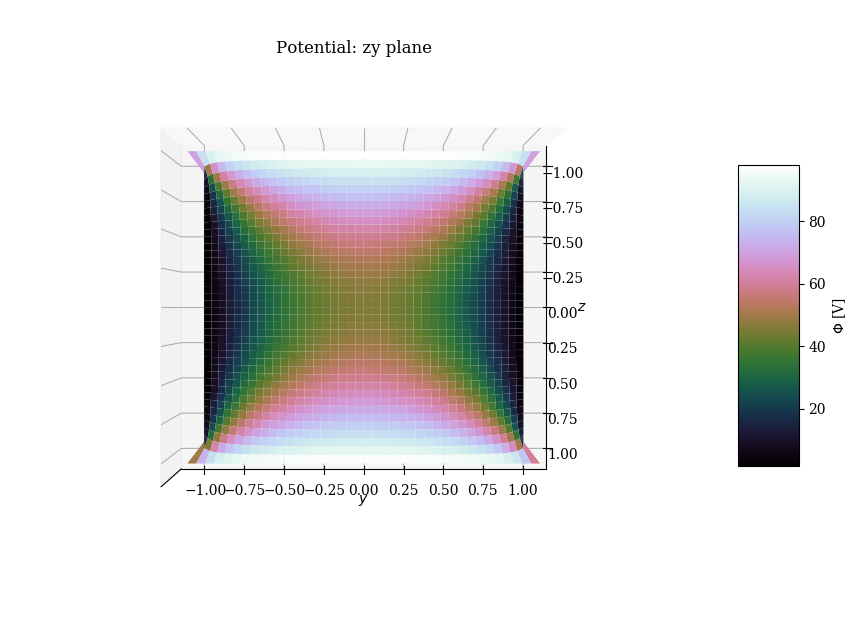

In [195]:
start_time = time.clock()

#plt.rc('text', usetex=False) 
plt.rc('font', family='serif')

def plot(z, y, V):
    fig = plt.figure(figsize=(11, 8), dpi=100)
    ax = fig.gca(projection='3d')
    Z, Y = np.meshgrid(z, y) #necessary step for surface plots 
    surf = ax.plot_surface(Z, Y, V, rstride=1, cstride=1, 
                           cmap=cm.cubehelix, linewidth=1, antialiased=True)
    ax.set_zticks([])
    ax.view_init(90, 0) #rotates the angles in the x and y planes
    ax.set_title('Potential: zy plane')
    ax.set_xlabel('$z$')
    ax.set_ylabel('$y$')
    #ax.set_zlabel('$V$')
    fig.colorbar(surf, shrink=0.5, aspect=5, label = '$\Phi$ [V]')

    #plt.savefig('parallelplates.png', dpi=100, format='png')

plot(z, y, V)   


print("Time elapsed: %s seconds" % (time.clock() - start_time))

Time elapsed: 0.173713 seconds


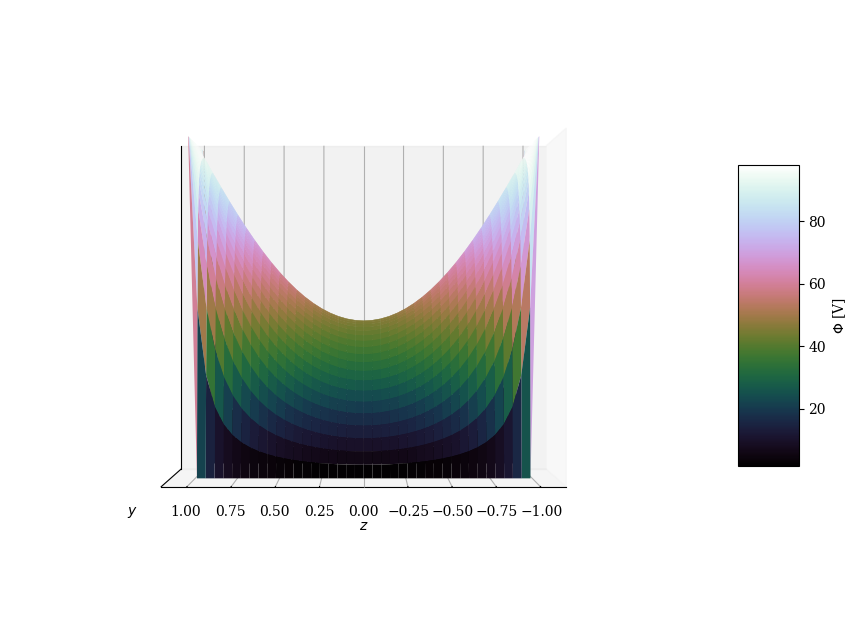

In [196]:
start_time = time.clock()

#plt.rc('text', usetex=False) 
plt.rc('font', family='serif')

def plot(z, y, V):
    fig = plt.figure(figsize=(11, 8), dpi=100)
    ax = fig.gca(projection='3d')
    Z, Y = np.meshgrid(z, y) #necessary step for surface plots 
    surf = ax.plot_surface(Z, Y, V, rstride=1, cstride=1, 
                           cmap=cm.cubehelix, linewidth=1, antialiased=True)
    ax.set_zticks([])
    ax.set_yticks([])
    ax.view_init(0, 90) #rotates the angles in the x and y planes
    #ax.set_title('Potential: Parallel Plates')
    ax.set_xlabel('$z$')
    ax.set_ylabel('$y$')
    #ax.set_zlabel('$V$')
    fig.colorbar(surf, shrink=0.5, aspect=5, label = '$\Phi$ [V]')

plot(z, y, V)   



print("Time elapsed: %s seconds" % (time.clock() - start_time))

In [203]:
#for i in range(0,41):
#    print(max(V[:, i]))
    
    #print(min(V[i,:]))
print(max(V[:,19]))
print(max(V[:,20]))
print(200./4.)

46.084132733934595
45.93505652334294
50.0


## References 

[1] Barba, L.A., Forsyth, G.F. (2015). *12 Steps to Navier Stokes: Step 9: 2D Laplace Equation.* Retrieved        from http://nbviewer.jupyter.org/github/barbagroup/CFDPython/blob/master/lessons/12_Step_9.ipynb